# Open-Source Implementation of Deep Research w/ LangGraph
## STAT 5243 - Applied Data Science Bonus Project
## Team: Shayan Chowdhury, Anqi Wu, Thomas Bordino, Mei Yue

**"Deep Research"** refers to AI-powered systems that autonomously conduct multi-step research by searching, analyzing, and synthesizing information from a wide range of sources to generate comprehensive, well-cited reports[4][1][3]. Leading companies implementing similar deep research capabilities include OpenAI ([ChatGPT Deep Research](https://openai.com/index/introducing-deep-research/)), Google ([Gemini Deep Research](https://gemini.google/overview/deep-research/)), and Perplexity AI ([Perplexity Deep Research](https://www.perplexity.ai/hub/blog/introducing-perplexity-deep-research)), each offering advanced agentic workflows that leverage large language models for in-depth, expert-level analysis. 

For our bonus project, we chose to implement a deep research workflow using open-source language models deployed locally using Ollama. Our code is adapted from LangGraph's [implementation](https://github.com/langchain-ai/langchain/tree/main/examples/open_deep_research) of Deep Research but with significant refactoring and optimizations for the purposes of report generation using open-source language models deployed locally using Ollama. 

Main features:
- Using reasoning LLMs for report planning and reflection/grading to ensure each of the sections are well-researched and of high quality
- Allowing for human feedback and iteration on the report plan for greater flexibility (human-in-the-loop design)
- Web search integration with [Tavily](https://tavily.com/)
- Using [LangGraph](https://www.langchain.com/langgraph) for easier implementation of agentic workflows
- Parallel section writing for improved throughput and efficiency
- Memory-based checkpointing for partial runs

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# configuration.py
import os
from enum import Enum
from dataclasses import dataclass, fields
from typing import Any, Optional, Dict 

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass

DEFAULT_REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report""" 

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"
    GOOGLESEARCH = "googlesearch"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""
    report_structure: str = DEFAULT_REPORT_STRUCTURE # Defaults to the default report structure
    num_queries: int = 2 # Number of search queries to generate per iteration
    max_search_depth: int = 2 # Maximum number of reflection + search iterations
    planner_provider: str = "anthropic"  # Defaults to Anthropic as provider
    planner_model: str = "claude-3-7-sonnet-latest" # Defaults to claude-3-7-sonnet-latest
    writer_provider: str = "anthropic" # Defaults to Anthropic as provider
    writer_model: str = "claude-3-5-sonnet-latest" # Defaults to claude-3-5-sonnet-latest
    search_api: SearchAPI = SearchAPI.TAVILY # Default to TAVILY
    search_api_config: Optional[Dict[str, Any]] = None 

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

In [3]:
# state.py
from typing import Annotated, List, TypedDict, Literal
from pydantic import BaseModel, Field
import operator

class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.")
    research: bool = Field(description="Whether to perform web research for this section of the report.")
    content: str = Field(description="The content of the section.")   

class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.")

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(description="List of search queries.")

class Feedback(BaseModel):
    grade: Literal["pass","fail"] = Field(description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail').")
    follow_up_queries: List[SearchQuery] = Field(description="List of follow-up search queries.")

class ReportStateInput(TypedDict):
    topic: str # Report topic
    
class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(TypedDict):
    topic: str # Report topic    
    report_plan_feedback: str # Feedback on the report plan
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

class SectionState(TypedDict):
    topic: str # Report topic
    section: Section # Report section  
    search_iterations: int # Number of search iterations done
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

In [4]:
# graph.py
from typing import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt, Command

# from open_deep_research.state import (
#     ReportStateInput,
#     ReportStateOutput,
#     Sections,
#     ReportState,
#     SectionState,
#     SectionOutputState,
#     Queries,
#     Feedback
# )

from prompts import (
    report_planner_query_writer_instructions,
    report_planner_instructions,
    query_writer_instructions, 
    section_writer_instructions,
    final_section_writer_instructions,
    section_grader_instructions,
    section_writer_inputs,
    SECTION_WORD_LIMIT, 
    INTRO_WORD_LIMIT,
    CONCLUSION_WORD_LIMIT
)

# from open_deep_research.configuration import Configuration
from utils import (
    # format_sections, 
    get_config_value, 
    get_search_params, 
    select_and_execute_search
)

## UTIL FUNCTIONS (MOVE TO utils.py)
from langchain.chat_models import init_chat_model

def initialize_model(config, model_type: str, structured_output=None):
    """Helper function to initialize chat models with consistent configuration.
    
    Args:
        config: Configuration object containing model settings
        model_type: Either "planner" or "writer" to determine which model to initialize
        structured_output: Optional class for structured output formatting
        
    Returns:
        Initialized chat model, optionally with structured output capability
    """
    if model_type == "planner":
        provider = get_config_value(config.planner_provider)
        model_name = get_config_value(config.planner_model)
        
        # Special handling for Claude 3.7 Sonnet
        if model_name == "claude-3-7-sonnet-latest":
            model = init_chat_model(
                model=model_name,
                model_provider=provider,
                max_tokens=20_000,
                thinking={"type": "enabled", "budget_tokens": 16_000}
            )
        else:
            model = init_chat_model(model=model_name, model_provider=provider)
    else:  # writer
        provider = get_config_value(config.writer_provider)
        model_name = get_config_value(config.writer_model)
        model = init_chat_model(model=model_name, model_provider=provider)
    
    # Apply structured output if provided
    if structured_output:
        return model.with_structured_output(structured_output)
    
    return model

## Nodes -- 

async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """Generates report plan with sections by:
        1. Generating search queries to gather context for planning
        2. Performing web searches using those queries
        3. Using a reasoning LLM to generate a structured plan with sections
    
    Args:
        state: Graph state w/ report topic
        config: Config for models, search APIs, etc.
        
    Returns:
        Dict with generated sections
    """

    # Inputs
    topic = state["topic"]
    feedback = state.get("report_plan_feedback", None)

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    num_queries = configurable.num_queries
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # # Convert JSON object to string if necessary
    # if isinstance(report_structure, dict): report_structure = str(report_structure)

    # WRITER MODEL: used for query writing
    writer_llm = initialize_model(configurable, "writer", structured_output=Queries)

    # Format instructions and generate queries
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, num_queries=num_queries)
    results = writer_llm.invoke([
        SystemMessage(content=system_instructions_query),
        HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Given the generated queries, search the web and get the source strings
    query_list = [query.search_query for query in results.queries]
    source_str = await select_and_execute_search(search_api, query_list, params_to_pass)

    # PLANNER MODEL: used for report planning
    planner_llm = initialize_model(configurable, "planner", structured_output=Sections)

    # Format instructions and generate sections
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)
    report_sections = planner_llm.invoke([
        SystemMessage(content=system_instructions_sections),
        HumanMessage(content="""Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. 
                     Each section must have: name, description, plan, research, and content fields.""")])

    return {"sections": report_sections.sections}

def get_human_feedback(state: ReportState, config: RunnableConfig) -> Command[Literal["generate_report_plan","build_section_w_web_research"]]:
    """Get human feedback on the report plan and route to next steps by:
    1. Formatting current report plan for human review
    2. Getting feedback via an interrupt
    3. Routing to either:
       - Section writing if plan is approved
       - Plan regeneration if feedback is provided
    
    Args:
        state: Graph state w/ sections to review
        config: Config for workflow
        
    Returns:
        Command to regenerate plan OR start section writing
    """

    # Get sections
    topic = state["topic"]
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    interrupt_message = f"""Please provide feedback on the following report plan. 
                        \n\n{sections_str}\n
                        \nDoes the report plan meet your needs?\nPass 'true' to approve the report plan.\nOr, provide feedback to regenerate the report plan:"""
    
    feedback = interrupt(interrupt_message)

    # If the user approves the report plan, kick off section writing
    if isinstance(feedback, bool) and feedback is True:
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_w_web_research", {"topic": topic, "section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ])
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # Treat this as feedback
        return Command(goto="generate_report_plan", 
                       update={"report_plan_feedback": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")
    
def generate_queries(state: SectionState, config: RunnableConfig):
    """Generate search queries for researching a specific section.
    
    This node uses an LLM to generate targeted search queries based on the 
    section topic and description.
    
    Args:
        state: Current state containing section details
        config: Configuration including number of queries to generate
        
    Returns:
        Dict containing the generated search queries
    """

    # Get state and configuration
    topic = state["topic"]
    section = state["section"]
    configurable = Configuration.from_runnable_config(config)
    num_queries = configurable.num_queries

    # Generate queries 
    writer_llm = initialize_model(configurable, "writer", structured_output=Queries)

    # Format instructions and generate queries
    system_instructions = query_writer_instructions.format(
        topic=topic, section_topic=section.description, num_queries=num_queries)
    queries = writer_llm.invoke([
        SystemMessage(content=system_instructions),
        HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState, config: RunnableConfig):
    """Execute web searches for the section queries using search API
    
    Args:
        state: Graph state w/ search queries
        config: Search API configuration
        
    Returns:
        Dict w/ search results and updated iteration count
    """

    # Get state and configuration
    search_queries = state["search_queries"]
    configurable = Configuration.from_runnable_config(config)
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # Search the web with parameters and get source strings
    query_list = [query.search_query for query in search_queries]
    source_str = await select_and_execute_search(search_api, query_list, params_to_pass)

    return {"source_str": source_str, "search_iterations": state["search_iterations"] + 1}

def write_section(state: SectionState, config: RunnableConfig) -> Command[Literal[END, "search_web"]]:
    """Write a section of the report and evaluate if more research is needed
    Routes to either:
       - Completing the section if quality passes
       - Conducting more research if quality fails
    
    Args:
        state: Graph state w/ search results and section info
        config: Config for writing and evaluation
        
    Returns:
        Command to either complete section OR do more research
    """

    # Get state and configuration
    topic = state["topic"]
    section = state["section"]
    source_str = state["source_str"]
    configurable = Configuration.from_runnable_config(config)

    # WRITER MODEL: to generate section content  
    writer_llm = initialize_model(configurable, "writer") 

    # Format instructions and generate section content
    section_writer_inputs_formatted = section_writer_inputs.format(
        topic=topic, section_name=section.name, section_topic=section.description, 
        context=source_str, section_content=section.content)
    section_content = writer_llm.invoke([
        SystemMessage(content=section_writer_instructions.format(SECTION_WORD_LIMIT=SECTION_WORD_LIMIT)),
        HumanMessage(content=section_writer_inputs_formatted)])
    
    # Write content to the section object
    section.content = section_content.content

    # PLANNER/REFLECTION MODEL: to grade the section and provide follow-up queries
    planner_llm = initialize_model(configurable, "planner", structured_output=Feedback)

    # Format instructions to generate feedback and follow-up queries
    section_grader_message = (
        "Grade the report and consider follow-up questions for missing information. "
        "If the grade is 'pass', return empty strings for all follow-up queries. "
        "If the grade is 'fail', provide specific search queries to gather missing information.")
    
    section_grader_instructions_formatted = section_grader_instructions.format(
        topic=topic, section_topic=section.description, section=section.content, 
        number_of_follow_up_queries=configurable.num_queries)

    feedback = planner_llm.invoke([
        SystemMessage(content=section_grader_instructions_formatted),
        HumanMessage(content=section_grader_message)])

    # If the section is passing or the max search depth is reached, publish the section to completed sections 
    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        # Publish the section to completed sections 
        return Command(update={"completed_sections": [section]}, goto=END)
    else:
        # Update the existing section with new content and update search queries
        return Command(update={"search_queries": feedback.follow_up_queries, "section": section}, goto="search_web")
    
def write_final_sections(state: SectionState, config: RunnableConfig):
    """Write sections that don't require research using completed sections as context

    Handles sections like conclusions or summaries that build on
    the researched sections rather than requiring direct research.
    
    Args:
        state: Graph state w/ completed sections as context
        config: Config for writing model
        
    Returns:
        Dict w/ newly written section
    """

    # Get state and configuration
    topic = state["topic"]
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    configurable = Configuration.from_runnable_config(config)
    
    # WRITER MODEL: to generate section content
    writer_llm = initialize_model(configurable, "writer") 

    # Format instructions and generate section content
    system_instructions = final_section_writer_instructions.format(topic=topic, section_name=section.name, section_topic=section.description, context=completed_report_sections, INTRO_WORD_LIMIT=INTRO_WORD_LIMIT, CONCLUSION_WORD_LIMIT=CONCLUSION_WORD_LIMIT)
    section_content = writer_llm.invoke([
        SystemMessage(content=system_instructions),
        HumanMessage(content="Generate a report section based on the provided sources.")])    
    
    # Write content to section 
    section.content = section_content.content
    # Write the updated section to completed sections
    return {"completed_sections": [section]}


def format_sections(sections: list[Section]) -> str:
    """Format a list of sections into a string"""
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
        {'='*60}
        Section {idx}: {section.name}
        {'='*60}
        Description:
        {section.description}
        Requires Research: 
        {section.research}

        Content:
        {section.content if section.content else '[Not yet written]'}
    """.replace("    ", "")
    return formatted_str


def gather_completed_sections(state: ReportState):
    """Format completed sections as context for writing final sections
    
    Takes all completed research sections and formats them into
    a single context string for writing summary sections.
    
    Args:
        state: Graph state w/ completed sections
        
    Returns:
        Dict w/ formatted sections as context
    """

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def compile_final_report(state: ReportState):
    """Compile all sections into the final report by:
        1. Fetching all completed sections
        2. Ordering them according to original plan
        3. Combining them into the final report
    
    Args:
        state: Graph state w/ all completed sections
        
    Returns:
        Dict w/ complete report
    """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

def initiate_final_section_writing(state: ReportState):
    """Create parallel tasks for writing non-research sections
    
    Identifies sections that don't need research and 
    creates parallel writing tasks for each one
    
    Args:
        state: Graph state w/ all sections and research context
        
    Returns:
        List of Send commands for parallel section writing
    """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"topic": state["topic"], "section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

# Report section sub-graph -- 

# Add nodes 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")

# Outer graph for initial report plan compiling results from each section -- 

# Add nodes
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("get_human_feedback", get_human_feedback)
builder.add_node("build_section_w_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "get_human_feedback")
builder.add_edge("build_section_w_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()

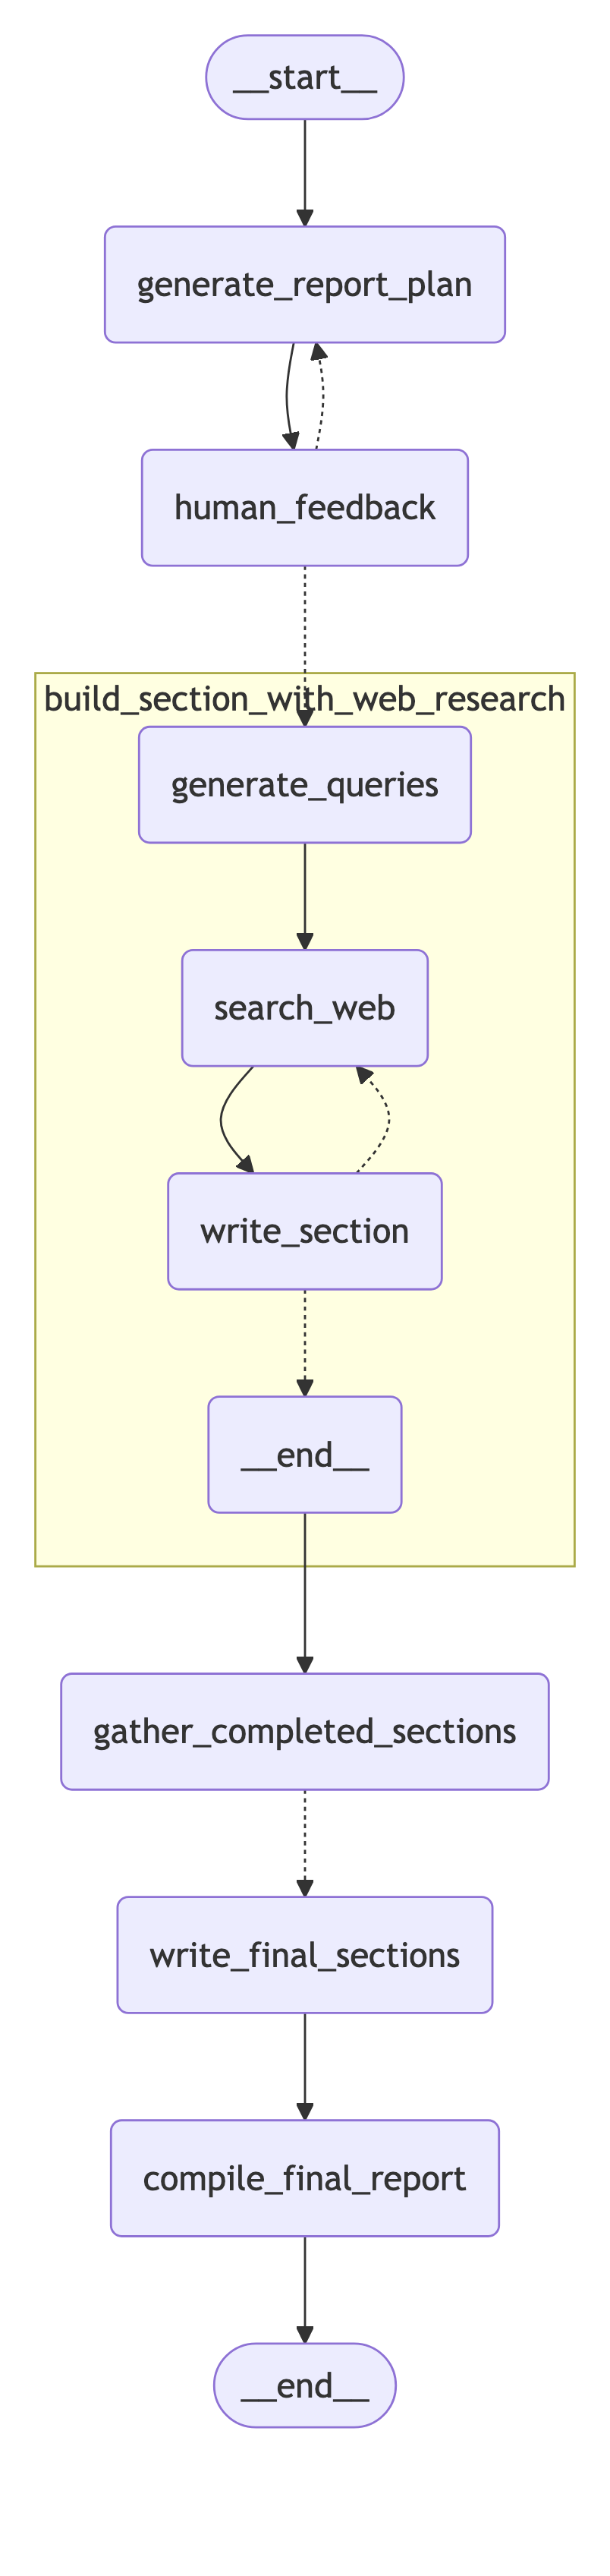

In [7]:
# main.py

from IPython.display import Image, display
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import nest_asyncio
nest_asyncio.apply() # Required for Jupyter Notebook to run async functions

# from open_deep_research.graph import builder

# Compile the graph with memory saver
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
display(Image(graph.get_graph(xray=1).draw_mermaid_png(
    curve_style=CurveStyle.BASIS, 
    node_colors=NodeStyles(first="#64784", last="#baffc9", default="#fad7de"), 
    output_file_path="./graph.png", 
    draw_method=MermaidDrawMethod.PYPPETEER, 
    background_color="white", 
    padding=1,
    )))

In [8]:
from dotenv import load_dotenv
load_dotenv(override=True)

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set the API keys used for any model or search tool selections below, such as:
# _set_env("OPENAI_API_KEY")
# _set_env("ANTHROPIC_API_KEY")
# _set_env("TAVILY_API_KEY")
# _set_env("GROQ_API_KEY")
# _set_env("PERPLEXITY_API_KEY")

In [9]:
import uuid 
from IPython.display import Markdown

REPORT_STRUCTURE = DEFAULT_REPORT_STRUCTURE # MODIFY THIS IF NEEDED

# # Claude 3.7 Sonnet for planning with perplexity search
# thread = {"configurable": {"thread_id": str(uuid.uuid4()),
#                            "search_api": "perplexity", # perplexity, tavily, groq, openai
#                            "planner_provider": "anthropic", # openai, groq, ollama
#                            "planner_model": "claude-3-7-sonnet-latest", # o3-mini, claude-3-5-sonnet-latest
#                            "writer_provider": "anthropic", # openai, groq, ollama
#                            "writer_model": "claude-3-5-sonnet-latest", # llama-3.3-70b-versatile, gemma3:1b
#                            "max_search_depth": 2, 
#                            "report_structure": REPORT_STRUCTURE,
#                            }}

# DeepSeek-R1-Distill-Llama-70B for planning and llama-3.3-70b-versatile for writing
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "planner_model": "deepseek-r1-distill-llama-70b",
                           "writer_provider": "groq",
                           "writer_model": "llama-3.3-70b-versatile",
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 3,}
                           }

# # Ollama: for planning and llama-3.3-70b-versatile for writing
# thread = {"configurable": {"thread_id": str(uuid.uuid4()),
#                            "search_api": "tavily",
#                            "planner_provider": "ollama",
#                            "planner_model": "qwen2.5:7b",
#                            "writer_provider": "ollama",
#                            "writer_model": "qwen2.5:7b",
#                            "report_structure": REPORT_STRUCTURE,
#                            "max_search_depth": 1,}
#                            }

# Create a topic
topic = "I want to ensure digitization of social protection schemes in my country of Bangladesh. What technological infrastructure, capabilities, policy environment, partnerships and funding will I need? Recommend the requirements for interoperable, secure and inclusive digital ID, payments and data exchange capabilities that we need in the country based on current context."

# Run the graph until the interruption
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Brief overview of the topic area
Research needed: No


Section: Technological Infrastructure
Description: Overview of the technological infrastructure needed for digitization
Research needed: Yes


Section: Capabilities
Description: Overview of the capabilities needed for digitization
Research needed: Yes


Section: Policy Environment
Description: Overview of the policy environment needed for digitization
Research needed: Yes


Section: Partnerships
Description: Overview of the partnerships needed for digitization
Research needed: Yes


Section: Funding
Description: Overview of the funding needed for digitization
Research needed: Yes


Section: Conclusion
Description: Summary of the main points
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

In [13]:
# Pass feedback to update the report plan  
feedback = "Include individuals sections for "
async for event in graph.astream(Command(resume=feedback), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Brief overview of the importance of digitizing social protection schemes in Bangladesh, setting the stage for the report.
Research needed: No


Section: Governance Framework
Description: Evaluating the current governance framework, including leadership, policy alignment, and institutional digital literacy. Recommending AI-driven analytics for decision-making and accountability.
Research needed: Yes


Section: Technology Architecture
Description: Recommending a modular, five-layer DPI framework (Identity, Payments, Data Exchange, Service Delivery, Inclusive Access) and strategies for integration with legacy systems.
Research needed: Yes


Section: ICT Industry Engagement
Description: Assessing the capabilities of the local ICT sector, benchmarking procurement processes, and advising on partnerships with technology providers.
Research needed: Yes


Section: Implementation Capacity
Description: Designing stakeholder engagement strategies, addressing cultural/operational barriers, and identifying process efficiencies for sustainable adoption. Strengthening institutional agility.
Research needed: Yes


Section: Financing Models
Description: Proposing innovative funding mechanisms and revenue models to ensure financial viability while aligning with national fiscal priorities.
Research needed: Yes


Section: Conclusion
Description: Summarizing the main findings and recommendations. Including a table that distills the main body sections into key recommendations.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

In [50]:
# Pass True to approve the report plan 
async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}




BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'The section content provides a good overview of the five-layer DPI framework and its components, but it lacks sufficient depth in several critical areas. It does not provide detailed strategies for integrating the layers with legacy systems, nor does it offer specific approaches for promoting long-term innovation. Additionally, the content does not adequately address the policy environment, funding requirements, or partnerships needed for successful implementation in Bangladesh. Therefore, the section content does not fully meet the requirements of the section topic.\n\nTo gather the missing information, the following search queries are recommended:\n\n1. "Strategies for integrating digital identity, payment, and data exchange systems with legacy infrastructure in Bangladesh"\n2. "Case studies on successful implementation of modular DPI frameworks in developing countries"\n3. "Funding sources and policy reforms required for digitizing social protection schemes in Bangladesh"\n4. "Technological challenges and solutions for inclusive access in Bangladesh\'s digital public infrastructure"\n5. "Best practices for promoting long-term innovation in digital public infrastructure"\n\nBy addressing these areas, the section content can be more comprehensive and effectively guide the digitization of social protection schemes in Bangladesh.'}}

In [30]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Introduction to Digitization of Social Protection Schemes in Bangladesh
The digitization of social protection schemes is a crucial step towards ensuring the effective and efficient delivery of benefits to vulnerable populations in Bangladesh. With a large and growing population, the country faces significant challenges in providing social protection to all those in need. The use of digital technologies can help address these challenges by improving the targeting and delivery of benefits, reducing errors and corruption, and enhancing the overall experience of beneficiaries. This report explores the technological infrastructure, capabilities, policy environment, partnerships, and funding required to support the digitization of social protection schemes in Bangladesh, with a focus on creating an interoperable, secure, and inclusive digital ecosystem. By leveraging digital technologies, Bangladesh can improve the lives of its citizens and achieve its development goals.

## Governance Framework
To establish a robust governance framework for digitizing social protection schemes in Bangladesh, it is essential to define clear digital transformation goals and identify gaps in leadership, policy alignment, and institutional digital literacy. The government can leverage AI-driven analytics to refine policies, establish people-centric success metrics, and foster accountability. According to the report "Amplifying Beneficiary Impact and Experience in G2P digital Transformation" [1], digital financial services can be a central redesign tool for social protection programs, which can inform Bangladesh's G2P programs and optimize beneficiary experience and impact.

The Common Narrative on Social Protection [2] presents a comprehensive framework for reforming the social protection system in Bangladesh, which can serve as a foundation for developing a governance framework. The document highlights the importance of adaptive social protection, which has gained prominence in light of the COVID-19 pandemic [3]. Adaptive social protection can help address the needs of vulnerable populations and ensure that social protection programs are responsive and effective.

To develop a governance framework that is equipped to handle the challenges of digitization, it is crucial to establish a strong institutional foundation. This can be achieved by investing in digital literacy and capacity-building programs for government officials and stakeholders. The use of AI-driven analytics can help policymakers make data-driven decisions and refine policies to better serve the needs of beneficiaries. As noted in the article "Explainable and transparent artificial intelligence for public policymaking" [4], machine learning and artificial intelligence technologies can ease and automate the analysis of large policy-related datasets, enabling policymakers to make more informed decisions.

Furthermore, the governance framework should prioritize transparency, accountability, and inclusivity. This can be achieved by establishing clear guidelines and protocols for data collection, storage, and sharing, as well as ensuring that digital platforms are accessible and user-friendly for all beneficiaries. The report "Artificial Intelligence for data-driven decision-making and governance in public affairs" [5] highlights the importance of extending the theoretical and practical boundaries of AI research in the public sector to improve governmental decision-making and governance.

In conclusion, a robust governance framework is essential for digitizing social protection schemes in Bangladesh. By leveraging AI-driven analytics, investing in digital literacy and capacity-building programs, and prioritizing transparency, accountability, and inclusivity, the government can establish a framework that supports the effective delivery of social protection programs and improves the lives of beneficiaries.

### Sources
[1] https://a2i.gov.bd/wp-content/uploads/2022/08/Amplifying-Beneficiary-Impact-and-Experience-in-G2P-digital-Transformation.pdf
[2] https://socialprotection.gov.bd/wp-content/uploads/2022/04/Social-Protection-in-Bangladesh-A-Common-Narrative.pdf
[3] https://socialprotection.gov.bd/2024/02/strategic-guidelines-and-action-plans-for-adaptive-social-protection-in-bangladesh/
[4] https://www.cambridge.org/core/journals/data-and-policy/article/explainable-and-transparent-artificial-intelligence-for-public-policymaking/51D4C6E27CFDEB3CD19EC5E1A6F4FAE7
[5] https://www.sciencedirect.com/science/article/pii/S0740624X22000788
[6] https://publicadministration.un.org/egovkb/Portals/egovkb/Documents/un/Bangladesh/CN+SDG+1.3.1+[Social+Inclusion]_21102018.pdf
[7] https://link.springer.com/chapter/10.1007/978-3-031-80478-6_9
[8] https://ppr.lse.ac.uk/articles/10.31389/lseppr.115
[9] https://academic.oup.com/policyandsociety/article/40/2/137/6509315
[10] https://www.hks.harvard.edu/faculty-research/policycast/ai-can-make-governing-better-instead-worse-yes-you-heard-right

## Technology Architecture
To establish a robust technology architecture for digitizing social protection schemes in Bangladesh, a modular, five-layer DPI framework is recommended. This framework consists of Identity, Payments, Data Exchange, Service Delivery, and Inclusive Access layers. 

The Identity layer will utilize the existing Porichoy digital identity infrastructure and e-KYC regulation [1] to provide a secure and unique identification system for beneficiaries. The Payments layer will leverage digital payment platforms to facilitate efficient and secure transactions, building on the experience of Bangladesh's phygital public infrastructure [1].

The Data Exchange layer will enable improved data correlation and triangulation across ministries, enhancing targeting for social safety net payments [1]. The Service Delivery layer will focus on optimizing beneficiary experience and impact, particularly for women, by presenting evidence from Bangladesh and other countries supporting digital financial services [2].

The Inclusive Access layer will prioritize building inclusive social protection systems, considering new sources of risk and vulnerabilities stemming from climate change, urbanization, and migration [3]. This layer will also ensure that the technology architecture is accessible to all segments of the population, including the most vulnerable.

To integrate these layers with legacy systems, a whole-of-society approach to DPI implementation is necessary, as seen in countries like Uruguay [4]. This approach will involve institutionalizing solutions, promoting long-term innovation, and fostering strategic partnerships and collaborations [5].

### Sources
[1] https://govinsider.asia/intl-en/article/bangladeshs-phygital-public-infrastructure-bridges-dpi-theory-and-practice
[2] https://a2i.gov.bd/wp-content/uploads/2022/08/Amplifying-Beneficiary-Impact-and-Experience-in-G2P-digital-Transformation.pdf
[3] https://artha.global/wp-content/uploads/2024/04/Leveraging-Digital-Public-Infrastructure-V2-1.pdf
[4] https://www.dpi-safeguards.org/countriesshowcase
[5] https://www.undp.org/digital/news/global-dpi-summit-outcome-statement

## ICT Industry Engagement
To assess the local ICT sector capabilities in Bangladesh, it is essential to evaluate the current state of the industry. According to Bangladesh's ICT Roadmap 2030, the country aims to revolutionize its technology sector and economy, positioning itself as a regional and global digital powerhouse [1]. The government's vision for establishing 'Digital Bangladesh' also emphasizes the development of a culture of digital adoption for social and economic development [2].

The ICT sector in Bangladesh has shown significant growth, with the government's Digital Bangladesh Vision 2021 initiative being a key driver of this growth [3]. The ICT Division was formed to address the rapid changes and growth opportunities presented by the ICT sector, with a focus on enhancing productivity, enabling innovation, and improving public services [4]. The National ICT Policy, deployed in 2009, also aims to improve the local startup ecosystem, with initiatives such as the IDEA Project and Startup Bangladesh Limited [5].

To foster partnerships and create a competitive ICT ecosystem, it is crucial to adopt a partnership ecosystem strategy that promotes co-innovation and collaboration [6]. This can be achieved by partnering with technology providers, startups, and local businesses to explore innovative solutions [7]. The government can also play a key role in supporting the ICT sector by providing funding and resources, such as the 100 crore BDT (U$ 11.5 Million) funds allocated to Startup Bangladesh Limited [5].

In terms of procurement processes, the introduction of e-GP (electronic government procurement) has eased the procurement process, but more needs to be done to deliver the expected level of positive impact in terms of corruption control and quality of the procured work [8]. The ICT Ministry is proposing interventions to tackle the existing systemic and regulatory shortcomings of the Startup Ecosystem, including partnering with ICT Division, Bangladesh Bank, and Startup Bangladesh [9].

### Sources
[1] https://meatechwatch.com/2025/02/12/bangladeshs-ict-roadmap-2030-a-vision-for-digital-transformation-and-global-leadership/
[2] https://mincom.portal.gov.bd/sites/default/files/files/mincom.portal.gov.bd/page/ea46a636_8607_44a7_b4bc_e1e336c8a663/03-01-2022+(31)+New.pdf
[3] https://markwideresearch.com/bangladesh-ict-market/
[4] https://www.ampar.com.bd/ict-division-of-bangladesh-pioneering-digital-transformation-for-a-smart-nation-by-2041/
[5] https://lightcastlepartners.com/insights/2020/09/summary-of-bangladesh-startup-ecosystem-the-untapped-digital-goldmine-of-asia/
[6] https://www.techtarget.com/searchitchannel/feature/Partner-ecosystem-strategy-Co-innovation-and-other-variants
[7] https://www.telecomreview.com/articles/reports-and-coverage/7666-the-power-of-partnership-in-the-ict-ecosystem/
[8] https://ti-bangladesh.org/images/2023/report/e-gp/e-GP-main-report.pdf?v=1
[9] https://ictd.portal.gov.bd/sites/default/files/files/ictd.portal.gov.bd/page/6c9773a2_7556_4395_bbec_f132b9d819f0/ICT+Roadmap_two-pager_Startup+Ecosystem.pdf

## Implementation Capacity
To ensure the successful digitization of social protection schemes in Bangladesh, it is crucial to design effective stakeholder engagement strategies, address cultural and operational barriers, and identify process efficiencies. This can be achieved by supporting the expansion of coverage of those experiencing poverty or vulnerable to it, as well as addressing risks and contingencies throughout their lifecycle, as highlighted by the Digital transformation of social protection information systems [1]. 

Modernizing access to social protection, as discussed by the OECD [2], is also essential, as it can help identify, enroll, and provide benefits and services to all those in need. Advances in digital technologies can facilitate this process, enabling the development of integrated tools for enrollment, targeting, payment, grievance redress, data management, and information systems, as seen in the Beneficiary FIRST Social Protection Project [3].

However, it is also important to consider the challenges of technology adoption in Bangladesh, including limited connectivity, economic inequality, poor infrastructure, and cultural barriers [4]. To overcome these obstacles, it is necessary to address data protection gaps and vulnerabilities, as well as ensure access to digital services, including digital connectivity, digital financial services, e-health, and online education [5, 6, 7].

Furthermore, the implementation of digital ID systems can have a significant impact on local populations, and it is essential to understand the true effect of these systems, as highlighted by the Bangladesh Case Study on Digital ID [8]. By addressing these challenges and barriers, Bangladesh can strengthen its institutional agility to adapt to evolving digital demands and ensure sustainable adoption of digital solutions.

### Sources
[1] Digital transformation of social protection information systems: https://globalallianceagainsthungerandpoverty.org/policy-instruments/digital-transformation-of-social-protection-information-systems/
[2] Modernising Access to Social Protection - OECD: https://www.oecd.org/en/publications/modernising-access-to-social-protection_af31746d-en.html
[3] Stakeholder Engagement Plan (SEP) - Beneficiary FIRST Social Protection Project: https://documents1.worldbank.org/curated/en/997601598848533070/pdf/Stakeholder-Engagement-Plan-SEP-Beneficiary-FIRST-Social-Protection-Project-P174066.pdf
[4] Challenges of Technology Adoption in Bangladesh: https://eikiyo.com/2024/12/12/challenges-of-technology-adoption-in-bangladesh/
[5] Policy brief: DSP Access and Equity in Africa: https://www.ituc-africa.org/IMG/pdf/policy_brief_dsp_2_dsp_access_and_equity_in_africa_09dec2024.pdf
[6] Barriers to Digital Services Adoption in Bangladesh: https://opendocs.ids.ac.uk/articles/report/Barriers_to_Digital_Services_Adoption_in_Bangladesh/26431264
[7] Barriers to Digital Services Adoption in Bangladesh - GOV.UK: https://www.gov.uk/research-for-development-outputs/barriers-to-digital-services-adoption-in-bangladesh
[8] Bangladesh Case Study - DigitalID - The Engine Room: https://digitalid.theengineroom.org/assets/pdfs/[English]+Bangladesh+Case+Study+-+DigitalID+-+The+Engine+Room.pdf

## Financing Models
To ensure the financial viability of digitization of social protection schemes in Bangladesh, innovative funding mechanisms and revenue models are necessary. The country can explore financing methods such as taxation, social impact bonds, and pensions to support social protection initiatives. According to the World Bank, a social protection floor ensures access to benefits for the population, but in low-income countries, it is inconceivable without external aid [4].

Bangladesh can leverage its digital financial landscape to increase revenue collection. Digital tools such as online tax filing, mobile financial services (e.g., bKash), and automated invoicing systems provide the government with more efficient ways to collect revenue [6]. The country can also develop incentive mechanisms, such as tax breaks for businesses in priority sectors, to encourage investment in sustainable finance [7].

In addition, Bangladesh can explore innovative financing methods, such as matched funding of commercial investment schemes, to support social protection initiatives [1]. The government can also establish risk-sharing mechanisms for sustainability bonds and catalytic capital to encourage investment [7]. By diversifying its funding sources and exploring innovative financing models, Bangladesh can reduce its dependency on external aid and ensure the financial sustainability of its social protection schemes.

The government can also utilize digital transformation to drive economic growth and increase revenue collection. By investing in digital infrastructure, human capital, and finance, Bangladesh can create a conducive environment for sustainable economic growth [8]. Furthermore, the country can develop a smart city initiative to enhance service delivery and improve revenue collection [9].

### Sources
[1] Innovative financing methods for social protection - GSDRC: https://gsdrc.org/publications/innovative-financing-methods-for-social-protection-/
[2] Social-protection-financing: https://gsdrc.org/wp-content/uploads/2017/10/Social-protection-financing.pdf
[3] Digital Social Protec-tion Working Group: https://spdci.org/wp-content/uploads/2022/12/230216_giz_sosi_pub-03_v27.pdf
[4] CKEx21-May-26-SP-Financing-Summary-FINAL: https://thedocs.worldbank.org/en/doc/3670e574b6095af68cae93dd43128268-0380022021/original/CKEx21-May-26-SP-Financing-Summary-FINAL.pdf
[5] SPJCC19SSND8S1PickFinancingSocialProtection: https://thedocs.worldbank.org/en/doc/226901575490840997-0160022019/original/SPJCC19SSND8S1PickFinancingSocialProtection.pdf
[6] Digital Transformation in Bangladesh: A Pathway to Economic: https://www.linkedin.com/pulse/digital-transformation-bangladesh-pathway-economic-johnny-shahinur-yu6ee
[7] Sustainable Finance: Driving Growth in Bangladesh: https://lightcastlepartners.com/insights/2025/02/sustainable-finance-bangladesh-economic-growth/
[8] Bangladesh+Strategy+Primer+Accessible: https://pathwayscommission.bsg.ox.ac.uk/sites/default/files/2021-11/Bangladesh+Strategy+Primer+Accessible.pdf
[9] Bangladesh-updated: https://thedocs.worldbank.org/en/doc/b5dced6dced2e09ea36c97ed2651a7b0-0090012023/original/Bangladesh-updated.pdf

## Conclusion
To ensure the successful digitization of social protection schemes in Bangladesh, it is essential to consider the technological infrastructure, capabilities, policy environment, partnerships, and funding required. The following key elements are crucial for a comprehensive approach:
* A robust governance framework that defines clear digital transformation goals and identifies gaps in leadership, policy alignment, and institutional digital literacy
* A modular, five-layer DPI framework consisting of Identity, Payments, Data Exchange, Service Delivery, and Inclusive Access layers
* Effective stakeholder engagement strategies and partnerships with technology providers to foster a competitive local ICT ecosystem
* Innovative funding mechanisms and revenue models to reduce dependency on external aid and ensure financial viability for DPI initiatives
The next steps should focus on implementing these elements, addressing cultural and operational barriers, and ensuring sustainable adoption of digital solutions to improve the lives of beneficiaries in Bangladesh.

In [33]:
print(report)

AIMessage(content="Hello there! 👋 It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-03-15T20:58:13.533705Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2210873625, 'load_duration': 1754392333, 'prompt_eval_count': 13, 'prompt_eval_duration': 161000000, 'eval_count': 20, 'eval_duration': 292000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-e0d4b9e3-af2d-46f5-9289-b886e4f51ff0-0', usage_metadata={'input_tokens': 13, 'output_tokens': 20, 'total_tokens': 33})